In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from scipy import stats
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GroupKFold
from imblearn.over_sampling import RandomOverSampler
from sklearn.utils.class_weight import compute_class_weight
import seaborn as sns
import torch.nn.functional as F

## Îç∞Ïù¥ÌÑ∞ Î°úÎìú / EDA / Ï†ÑÏ≤òÎ¶¨

### Îç∞Ïù¥ÌÑ∞ Î°úÎìú

In [3]:
file = open("C:/Users/c/Desktop/ML programming/WISDM_ar_v1.1_raw.txt")

In [4]:
lines = file.readlines()

processedList = []

for i, line in enumerate(lines):
    try:
        line = line.split(',')
        last = line[5].split(';')[0]
        last = last.strip()
        if last == '':
            break;
        temp = [line[0], line[1], line[2], line[3], line[4], last]
        processedList.append(temp)
    except:
        print('Error at line number: ', i)

Error at line number:  281873
Error at line number:  281874
Error at line number:  281875


In [5]:
# Ïª¨Îüº Ï∂îÍ∞Ä
columns = ['user', 'activity', 'time', 'x', 'y', 'z']

In [6]:
df = pd.DataFrame(data = processedList, columns = columns)
df['x'] = df['x'].astype('float')
df['y'] = df['y'].astype('float')
df['z'] = df['z'].astype('float')
df['user'] = df['user'].astype('int')
df.head()

user activity            time         x          y         z
0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953
1    33  Jogging  49106062271000  5.012288  11.264028  0.953424
2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722
3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717
4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164

### EDA

In [7]:
df.isnull().sum()

user        0
activity    0
time        0
x           0
y           0
z           0
dtype: int64

In [8]:
df['activity'].value_counts()

activity
Walking       137375
Jogging       129392
Upstairs       35137
Downstairs     33358
Sitting         4599
Standing        3555
Name: count, dtype: int64

C:\Users\c\AppData\Local\Temp\ipykernel_16660\3400418400.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x=user_counts.index, y=user_counts.values, palette='viridis')


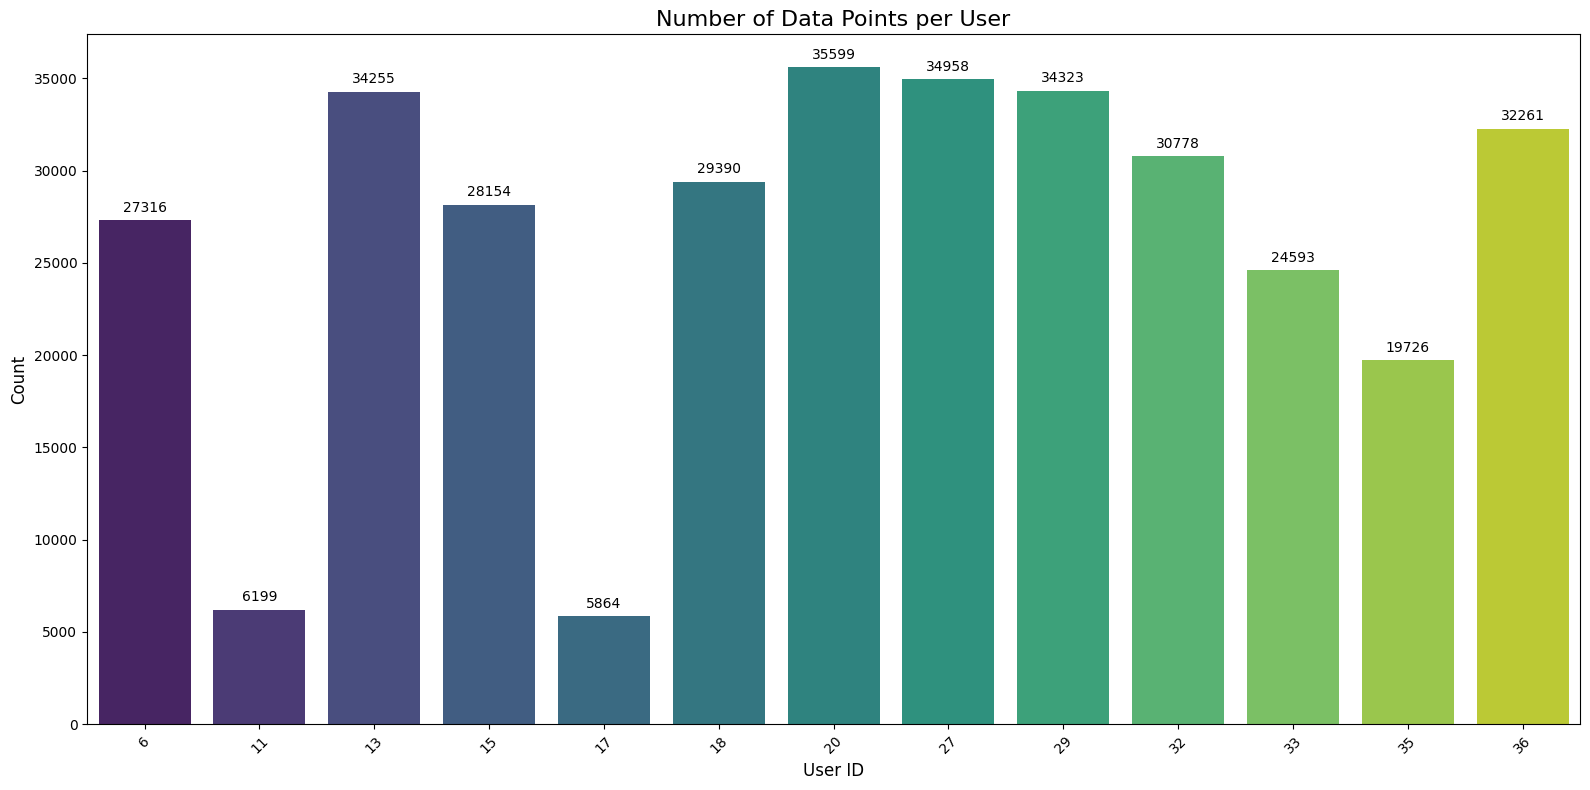

In [9]:
user_counts = df['user'].value_counts()

plt.figure(figsize=(16, 8)) 
barplot = sns.barplot(x=user_counts.index, y=user_counts.values, palette='viridis')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.title('Number of Data Points per User', fontsize=16)
plt.xlabel('User ID', fontsize=12)
plt.ylabel('Count', fontsize=12)
plt.xticks(rotation=45) 
plt.tight_layout() 
plt.show()

C:\Users\c\AppData\Local\Temp\ipykernel_16660\1733336201.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Group', y='Total Count', data=comparison_df, palette='rocket')


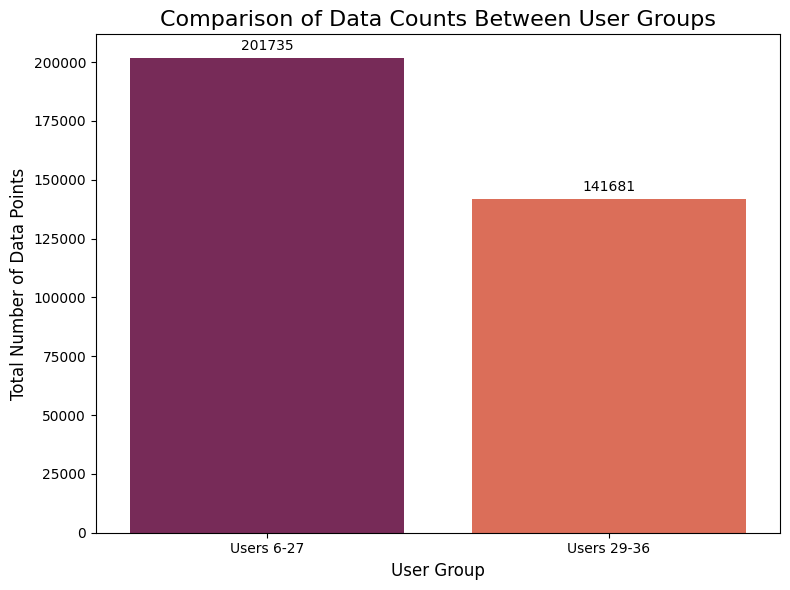

In [10]:
user_counts = df['user'].value_counts()

group_a_mask = (user_counts.index >= 6) & (user_counts.index <= 27)
group_a_sum = user_counts[group_a_mask].sum()

group_b_mask = (user_counts.index >= 29) & (user_counts.index <= 36)
group_b_sum = user_counts[group_b_mask].sum()

plt.figure(figsize=(8, 6))
comparison_df = pd.DataFrame({
    'Group': ['Users 6-27', 'Users 29-36'],
    'Total Count': [group_a_sum, group_b_sum]
})
barplot = sns.barplot(x='Group', y='Total Count', data=comparison_df, palette='rocket')

for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.0f'),
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha = 'center', va = 'center',
                     xytext = (0, 9),
                     textcoords = 'offset points')

plt.title('Comparison of Data Counts Between User Groups', fontsize=16)
plt.ylabel('Total Number of Data Points', fontsize=12)
plt.xlabel('User Group', fontsize=12)
plt.tight_layout()
plt.show()

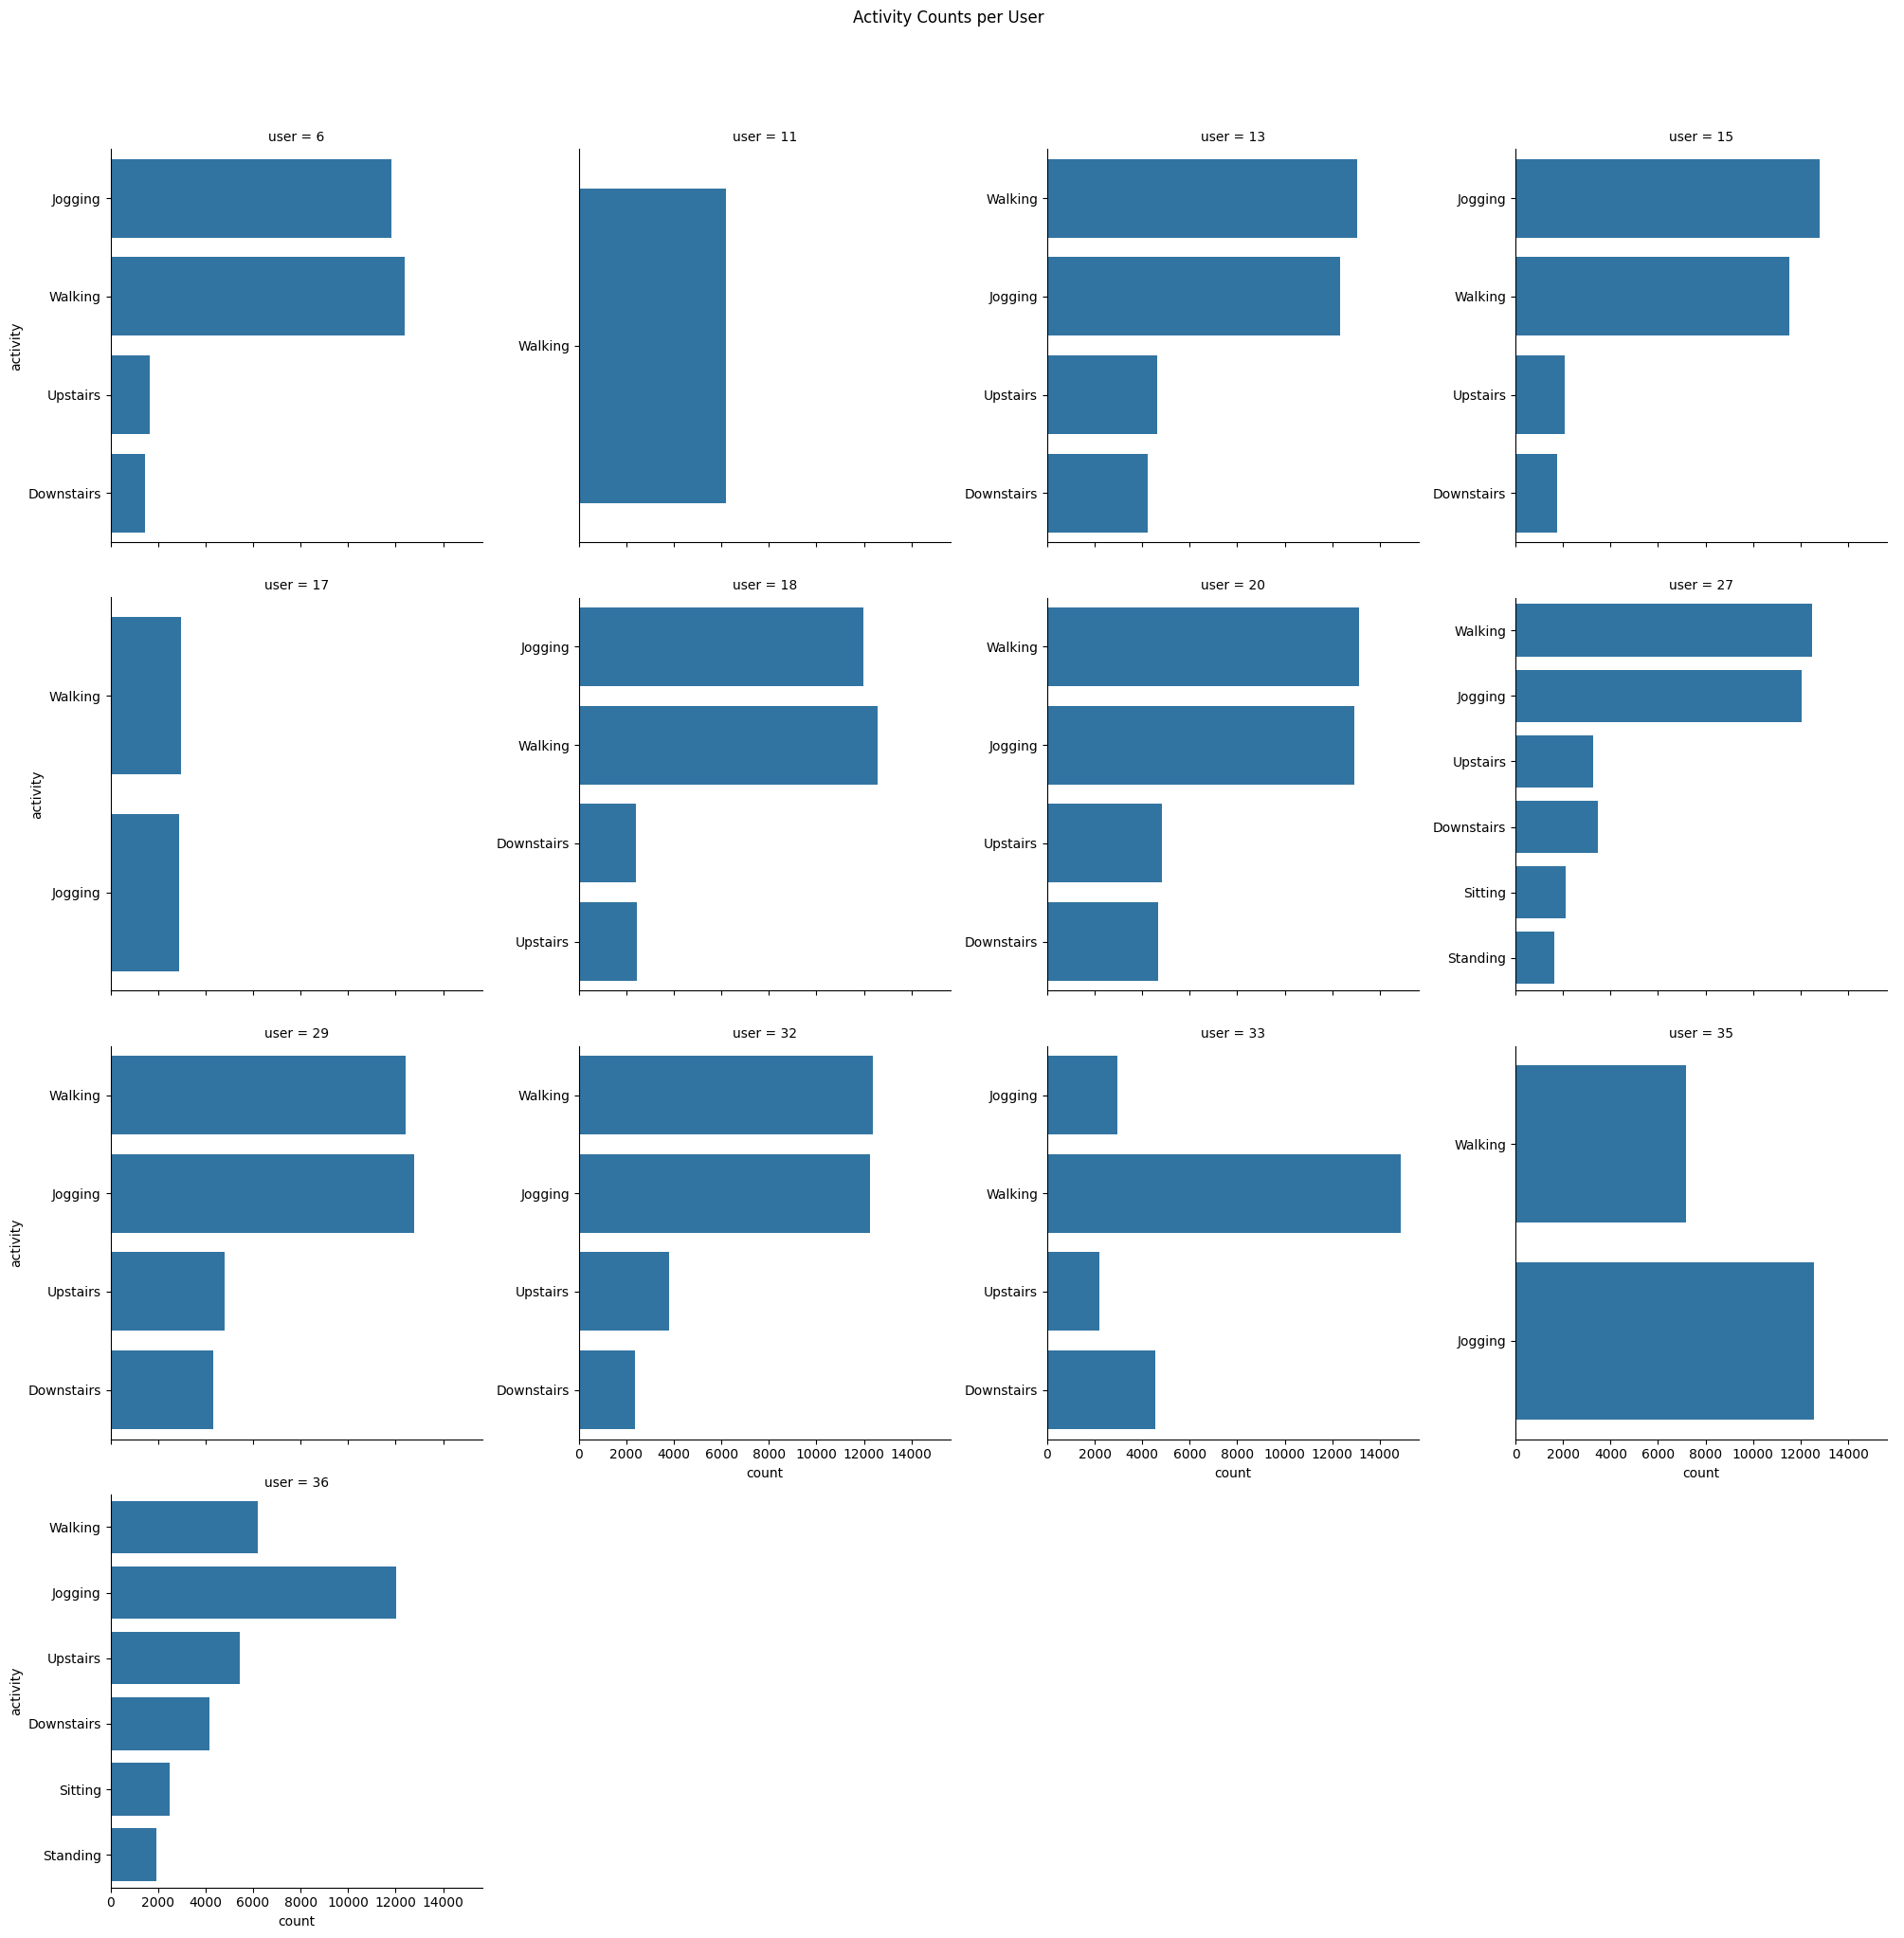

In [11]:
g = sns.catplot(data=df, y='activity', col='user', kind='count', 
                height=5, aspect=1, col_wrap=4, sharey=False)

g.fig.suptitle('Activity Counts per User', y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.98])
plt.show()

### Ï†ÑÏ≤òÎ¶¨

In [12]:
test_df = df[df['user'] > 27]
train_df = df[df['user'] <= 27]
test_df.shape, train_df.shape

((141681, 6), (201735, 6))

In [13]:
def feature_engineering(df):
    df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
        
    feature_cols = ['x', 'y', 'z', 'magnitude']
    for col in feature_cols:

        df[f'{col}_std'] = df.groupby('user')[col].rolling(
            window=80, 
            min_periods=1
        ).std().reset_index(level=0, drop=True)
        
    df.fillna(method='ffill', inplace=True)
    df.fillna(0, inplace=True)
    return df

test_df = feature_engineering(test_df)
train_df = feature_engineering(train_df)

test_df.head(), train_df.head()


C:\Users\c\AppData\Local\Temp\ipykernel_16660\1676528177.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['magnitude'] = np.sqrt(df['x']**2 + df['y']**2 + df['z']**2)
C:\Users\c\AppData\Local\Temp\ipykernel_16660\1676528177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_std'] = df.groupby('user')[col].rolling(
C:\Users\c\AppData\Local\Temp\ipykernel_16660\1676528177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_inde

(   user activity            time         x          y         z  magnitude  \
 0    33  Jogging  49105962326000 -0.694638  12.680544  0.503953  12.709551   
 1    33  Jogging  49106062271000  5.012288  11.264028  0.953424  12.365693   
 2    33  Jogging  49106112167000  4.903325  10.882658 -0.081722  11.936562   
 3    33  Jogging  49106222305000 -0.612916  18.496431  3.023717  18.751973   
 4    33  Jogging  49106332290000 -1.184970  12.108489  7.205164  14.139804   
 
       x_std     y_std     z_std  magnitude_std  
 0  0.000000  0.000000  0.000000       0.000000  
 1  4.035406  1.001628  0.317824       0.243144  
 2  3.263895  0.947308  0.519065       0.387277  
 3  3.240326  3.529472  1.350791       3.222902  
 4  3.178345  3.105116  2.970432       2.792531  ,
       user activity            time         x          y         z  magnitude  \
 8489    17  Walking  57869902574000  0.572055   9.806650 -0.531194   9.837672   
 8490    17  Walking  57870012316000 -0.000000  10.188020 -

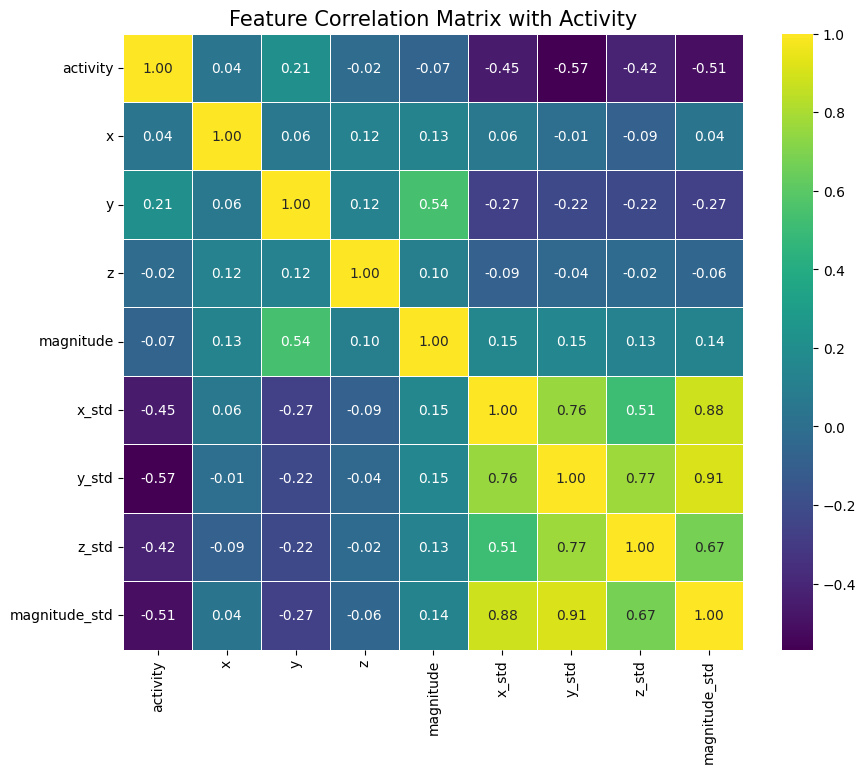

In [14]:
corr_df = train_df.copy()

# ÏãúÍ∞ÅÌôîÏö© LabelEncoder ÏÉùÏÑ± Î∞è Ï†ÅÏö©
le_corr = LabelEncoder()
corr_df['activity'] = le_corr.fit_transform(corr_df['activity'])

# ÏÉÅÍ¥ÄÍ¥ÄÍ≥Ñ Î∂ÑÏÑùÌï† ÌäπÏÑ± ÏÑ†ÌÉù (activity Ìè¨Ìï®)
features_for_corr = ['activity', 'x', 'y', 'z', 'magnitude', 'x_std', 'y_std', 'z_std', 'magnitude_std']
corr_matrix = corr_df[features_for_corr].corr()

# ÏãúÍ∞ÅÌôî
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='viridis', fmt='.2f', linewidths=.5)
plt.title('Feature Correlation Matrix with Activity', fontsize=15)
plt.show()


In [15]:
label_encoder = LabelEncoder()

train_df['activity'] = label_encoder.fit_transform(train_df['activity'])
test_df['activity'] = label_encoder.transform(test_df['activity'])

C:\Users\c\AppData\Local\Temp\ipykernel_16660\4128002732.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['activity'] = label_encoder.fit_transform(train_df['activity'])
C:\Users\c\AppData\Local\Temp\ipykernel_16660\4128002732.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['activity'] = label_encoder.transform(test_df['activity'])


In [16]:
feature_columns_to_scale = ['x', 'y', 'z', 'magnitude', 'x_std', 'y_std', 'z_std', 'magnitude_std']

scaler = StandardScaler()
train_df[feature_columns_to_scale] = scaler.fit_transform(train_df[feature_columns_to_scale])

test_df[feature_columns_to_scale] = scaler.transform(test_df[feature_columns_to_scale])

C:\Users\c\AppData\Local\Temp\ipykernel_16660\218149100.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df[feature_columns_to_scale] = scaler.fit_transform(train_df[feature_columns_to_scale])
C:\Users\c\AppData\Local\Temp\ipykernel_16660\218149100.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df[feature_columns_to_scale] = scaler.transform(test_df[feature_columns_to_scale])


In [17]:
# hop_sizeÎ•º frame_size Î≥¥Îã§ ÏûëÍ≤å ÏÑ§Ï†ïÌïòÏó¨ Ï§ëÎ≥µÌïòÏó¨ Í≥†Î†§Ìï† Ïàò ÏûàÍ≤å Ìï® (Ïò§Î≤ÑÎûòÌïë)
Fs = 20
frame_size = Fs*4 # 80
hop_size = Fs*2 # 40
col = ['x_std', 'y_std', 'z_std', 'magnitude_std', 'activity']
feature_cols = ['x_std', 'y_std', 'z_std', 'magnitude_std']
label_col = 'activity'

In [18]:
def get_frames(df, frame_size, hop_size):
  """
  ÏãúÍ≥ÑÏó¥ Îç∞Ïù¥ÌÑ∞Î•º CNNÏù¥ Ïù¥Ìï¥Ìï† Ïàò ÏûàÍ≤å Ïû¨Íµ¨ÏÑ±Ìï®.
  x,y,z Í∞íÏùÑ Í∞ÅÍ∞ÅÏùò Ï±ÑÎÑêÎ°ú ÎÇòÎàÑÍ≥†
  Ïó∞ÏÜçÏ†ÅÏù∏ Îç∞Ïù¥ÌÑ∞Î•º ÎèÖÎ¶ΩÏ†ÅÏù∏ Ïó¨Îü¨Í∞úÏùò Îç∞Ïù¥ÌÑ∞Î°ú ÎÇòÎàî (Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∂ÑÌï†).
  Ïù¥Îäî Í≥†Ï†ïÎêú Í∏∏Ïù¥Ïùò ÏûÖÎ†•Îßå Î∞õÏùÑ Ïàò ÏûàÎäî CNN ÌäπÏÑ±ÏóêÏÑú Í∏∞Ïù∏Ìï®.

  Args:
    df: Îç∞Ïù¥ÌÑ∞ ÌîÑÎ†àÏûÑ
    frame_size: Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ Î∂ÑÌï† ÏÇ¨Ïù¥Ï¶à
    hop_size: Ïä¨ÎùºÏù¥Îî© ÏúàÎèÑÏö∞ ÏÇ¨Ïù¥Ï¶à

  Returns:
    frames: Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞
    labels: Î∂ÑÌï†Îêú Îç∞Ïù¥ÌÑ∞Ïùò Î†àÏù¥Î∏î
  """
  N_FEATURES = 8
  
  # ÏÇ¨Ïö©Ìï† ÌîºÏ≤ò Ïª¨Îüº Î™©Î°ù Ï†ïÏùò
  feature_columns = col

  frames = []
  labels = []
  for i in range(0, len(df) - frame_size, hop_size):
      frame = df[feature_cols].values[i: i + frame_size]
      label = df[label_col][i: i + frame_size].mode()[0]
      
      frames.append(frame)
      labels.append(label)

  # NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò
  frames = np.asarray(frames)
  labels = np.asarray(labels).astype(int)

  return frames, labels

In [19]:
class EarlyStopping:
    """Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ Í∞úÏÑ†ÎêòÏßÄ ÏïäÏúºÎ©¥ ÌïôÏäµÏùÑ Ï°∞Í∏∞Ïóê Ï§ëÎã®ÏãúÌÇµÎãàÎã§."""
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): Í≤ÄÏ¶ù ÏÜêÏã§Ïù¥ Í∞úÏÑ†Îêú ÌõÑ Í∏∞Îã§Î¶¨Îäî ÏóêÌè≠ Ïàò
            verbose (bool): TrueÏùº Í≤ΩÏö∞ Í∞Å Í∞úÏÑ† ÏÇ¨Ìï≠Ïóê ÎåÄÌïú Î©îÏãúÏßÄÎ•º Ï∂úÎ†•
            delta (float): Í∞úÏÑ†ÏúºÎ°ú Ïù∏Ï†ïÎ∞õÍ∏∞ ÏúÑÌïú ÏµúÏÜåÌïúÏùò Î≥ÄÌôîÎüâ
            path (str): Í∞ÄÏû• Ï¢ãÏùÄ Î™®Îç∏ÏùÑ Ï†ÄÏû•Ìï† Í≤ΩÎ°ú
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = np.inf
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        """Validation lossÍ∞Ä Í∞êÏÜåÌïòÎ©¥ Î™®Îç∏ÏùÑ Ï†ÄÏû•Ìï©ÎãàÎã§."""
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)
        self.val_loss_min = val_loss

## LSTM

In [20]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes, dropout=0.5):
        """
        :param input_size: ÏûÖÎ†• ÌîºÏ≤òÏùò Ïàò (Í∞Å ÏãúÏ†êÏùò Îç∞Ïù¥ÌÑ∞ Ï∞®Ïõê)
        :param hidden_size: LSTM hidden stateÏùò Ï∞®Ïõê
        :param num_layers: ÏåìÏùÑ LSTM Î†àÏù¥Ïñ¥Ïùò Ïàò
        :param num_classes: ÏµúÏ¢Ö Î∂ÑÎ•òÌï† ÌÅ¥ÎûòÏä§Ïùò Ïàò (Ïó¨Í∏∞ÏÑúÎäî 6)
        """
        super(LSTMClassifier, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)

        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        """
        xÏùò shape: (Î∞∞Ïπò ÌÅ¨Í∏∞, ÏãúÌÄÄÏä§ Í∏∏Ïù¥, input_size)
        """
        # Ï¥àÍ∏∞ hidden stateÏôÄ cell stateÎ•º 0ÏúºÎ°ú ÏÑ§Ï†ï
        # h0, c0Ïùò shape: (num_layers, Î∞∞Ïπò ÌÅ¨Í∏∞, hidden_size)
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # LSTM ÏàúÏ†ÑÌåå
        # out: Î™®Îì† ÏãúÏ†ê(time-step)Ïùò hidden state Ï∂úÎ†•
        # outÏùò shape: (Î∞∞Ïπò ÌÅ¨Í∏∞, ÏãúÌÄÄÏä§ Í∏∏Ïù¥, hidden_size)
        out, _ = self.lstm(x, (h0, c0))

        # ÎßàÏßÄÎßâ ÏãúÏ†êÏùò hidden stateÎßå ÏÑ†ÌÉùÌïòÏó¨ Î∂ÑÎ•òÍ∏∞Ïóê Ï†ÑÎã¨
        # out[:, -1, :]Îäî (Î∞∞Ïπò ÌÅ¨Í∏∞, hidden_size) shapeÎ•º Í∞ÄÏßê
        out = self.fc(out[:, -1, :])
        return out

In [21]:

model = LSTMClassifier(input_size=3, hidden_size=100, num_layers=2, num_classes=6)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

LSTMClassifier(
  (lstm): LSTM(3, 100, num_layers=2, batch_first=True)
  (fc): Linear(in_features=100, out_features=6, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)

In [24]:
# --- ÍµêÏ∞® Í≤ÄÏ¶ù ÏÑ§Ï†ï ---
n_splits = 5  # 5-Fold Cross Validation
groups = train_df['user']
gkf = GroupKFold(n_splits=n_splits)

# Í∞Å FoldÏùò ÌõàÎ†® Í∏∞Î°ùÏùÑ Ï†ÄÏû•Ìï† Î¶¨Ïä§Ìä∏
fold_histories = []

best_val_loss = float('inf')
best_model_path = ''

stopped_epochs = []

# --- ÍµêÏ∞® Í≤ÄÏ¶ù Î£®ÌîÑ ÏãúÏûë ---
for fold, (train_idx, val_idx) in enumerate(gkf.split(train_df, train_df['activity'], groups)):
    print(f"===================== FOLD {fold+1}/{n_splits} =====================")

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # --- 1. Îç∞Ïù¥ÌÑ∞ Ï†ÑÏ≤òÎ¶¨ (Îß§ FoldÎßàÎã§ ÏÉàÎ°ú ÏàòÌñâ) ---
    fold_train = train_df[col].iloc[train_idx]
    fold_val = train_df[col].iloc[val_idx]

    X_train, y_train = get_frames(fold_train, frame_size, hop_size)
    X_val, y_val = get_frames(fold_val, frame_size, hop_size)

    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)

    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # --- 2. Î™®Îç∏ Î∞è ÌïôÏäµ ÏöîÏÜå Ï¥àÍ∏∞Ìôî (Îß§ FoldÎßàÎã§ ÏÉàÎ°ú ÏàòÌñâ) ---

    model = LSTMClassifier(input_size=4, hidden_size=100, num_layers=2, num_classes=6)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.00001, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)
    

    # --- 3. DataLoader Î∞è EarlyStopping Ï¥àÍ∏∞Ìôî ---
    batch_size = 64
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    epochs = 100 # ÏµúÎåÄ ÏóêÌè≠ÏùÑ Ï∂©Î∂ÑÌûà Í∏∏Í≤å ÏÑ§Ï†ï
    patience = 5  # 5 ÏóêÌè≠ ÎèôÏïà Í∞úÏÑ†Ïù¥ ÏóÜÏúºÎ©¥ Ï§ëÎã®
    early_stopping = EarlyStopping(patience=patience, verbose=True, path=f'checkpoint_fold_{fold+1}.pt')

    # --- 4. ÌõàÎ†® Î£®ÌîÑ ---
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * inputs.size(0)

        train_loss = running_loss / len(train_loader.dataset)
        history['train_loss'].append(train_loss)

        # --- 5. Í≤ÄÏ¶ù Î£®ÌîÑ Î∞è Ï°∞Í∏∞ Ï¢ÖÎ£å Ìò∏Ï∂ú ---
        model.eval()
        running_test_loss = 0.0
        all_predictions = []
        all_labels = []
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                running_test_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                all_predictions.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        test_loss = running_test_loss / len(val_loader.dataset)
        test_accuracy = accuracy_score(all_labels, all_predictions)
        history['val_loss'].append(test_loss)
        history['val_acc'].append(test_accuracy)

        print(f"Epoch [{epoch+1}/{epochs}], Train Loss: {train_loss:.4f}, Val Loss: {test_loss:.4f}, Val Acc: {test_accuracy*100:.2f}%")

        scheduler.step(test_loss)

        # EarlyStopping Ìò∏Ï∂ú
        early_stopping(test_loss, model)
        if early_stopping.early_stop:
            stopped_epochs.append(epoch - patience + 1)
            print(f"Fold {fold+1} stopped at epoch {epoch - patience + 1}")
            break
        if not early_stopping.early_stop:
            stopped_epochs.append(epochs)
            print(f"Fold {fold+1} finished all {epochs} epochs.")

    # Í∞ÄÏû• ÏÑ±Îä•Ïù¥ Ï¢ãÏïòÎçò Î™®Îç∏Ïùò Í∏∞Î°ùÏùÑ Ï†ÄÏû•
    best_acc = max(history['val_acc'])
    fold_histories.append({'fold': fold+1, 'best_accuracy': best_acc, 'history': history})

    if early_stopping.val_loss_min < best_val_loss:
        print(f"‚ú® New best model found in Fold {fold+1} with Val Loss: {early_stopping.val_loss_min:.6f}")
        best_val_loss = early_stopping.val_loss_min
        best_model_path = early_stopping.path
    


# --- 6. ÏµúÏ¢Ö Í≤∞Í≥º Î∂ÑÏÑù ---
print("\n===================== Final Results =====================")
all_accuracies = [h['best_accuracy'] for h in fold_histories]
for i, acc in enumerate(all_accuracies):
    print(f"Fold {i+1} Best Accuracy: {acc*100:.2f}%")

print(f"\nAverage Accuracy: {np.mean(all_accuracies)*100:.2f}%")
print(f"Standard Deviation: {np.std(all_accuracies)*100:.2f}%")


===================== FOLD 1/5 =====================


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7701, Val Loss: 1.7591, Val Acc: 13.63%
Validation loss decreased (inf --> 1.759105).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7553, Val Loss: 1.7449, Val Acc: 48.09%
Validation loss decreased (1.759105 --> 1.744936).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7395, Val Loss: 1.7296, Val Acc: 50.11%
Validation loss decreased (1.744936 --> 1.729624).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7219, Val Loss: 1.7119, Val Acc: 50.23%
Validation loss decreased (1.729624 --> 1.711921).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7011, Val Loss: 1.6903, Val Acc: 50.23%
Validation loss decreased (1.711921 --> 1.690253).  Saving model ...
Fold 1 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.6749, Val Loss: 1.6613, Val Acc: 70.72%
Validation loss decreased (1.690253 --> 1.661283).  Saving model ...
Fold 1 finished a

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7551, Val Loss: 1.7545, Val Acc: 39.11%
Validation loss decreased (inf --> 1.754548).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7411, Val Loss: 1.7443, Val Acc: 62.61%
Validation loss decreased (1.754548 --> 1.744289).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7261, Val Loss: 1.7331, Val Acc: 67.09%
Validation loss decreased (1.744289 --> 1.733135).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7092, Val Loss: 1.7201, Val Acc: 68.00%
Validation loss decreased (1.733135 --> 1.720069).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.6893, Val Loss: 1.7042, Val Acc: 68.23%
Validation loss decreased (1.720069 --> 1.704208).  Saving model ...
Fold 2 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.6641, Val Loss: 1.6832, Val Acc: 68.35%
Validation loss decreased (1.704208 --> 1.683215).  Saving model ...
Fold 2 finished a

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7758, Val Loss: 1.7629, Val Acc: 40.86%
Validation loss decreased (inf --> 1.762896).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7614, Val Loss: 1.7500, Val Acc: 41.36%
Validation loss decreased (1.762896 --> 1.749957).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7463, Val Loss: 1.7360, Val Acc: 41.36%
Validation loss decreased (1.749957 --> 1.736025).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7297, Val Loss: 1.7204, Val Acc: 72.53%
Validation loss decreased (1.736025 --> 1.720436).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7104, Val Loss: 1.7019, Val Acc: 72.23%
Validation loss decreased (1.720436 --> 1.701866).  Saving model ...
Fold 3 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.6867, Val Loss: 1.6788, Val Acc: 72.33%
Validation loss decreased (1.701866 --> 1.678841).  Saving model ...
Fold 3 finished a

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.8107, Val Loss: 1.8053, Val Acc: 6.87%
Validation loss decreased (inf --> 1.805315).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7971, Val Loss: 1.7899, Val Acc: 6.87%
Validation loss decreased (1.805315 --> 1.789917).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7830, Val Loss: 1.7736, Val Acc: 6.87%
Validation loss decreased (1.789917 --> 1.773602).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7678, Val Loss: 1.7556, Val Acc: 6.87%
Validation loss decreased (1.773602 --> 1.755554).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7507, Val Loss: 1.7352, Val Acc: 51.46%
Validation loss decreased (1.755554 --> 1.735181).  Saving model ...
Fold 4 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.7306, Val Loss: 1.7108, Val Acc: 86.26%
Validation loss decreased (1.735181 --> 1.710758).  Saving model ...
Fold 4 finished all 1

c:\Users\c\Desktop\ML programming\venv\lib\site-packages\torch\optim\lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch [1/100], Train Loss: 1.7916, Val Loss: 1.7861, Val Acc: 5.85%
Validation loss decreased (inf --> 1.786054).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [2/100], Train Loss: 1.7796, Val Loss: 1.7722, Val Acc: 9.53%
Validation loss decreased (1.786054 --> 1.772182).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [3/100], Train Loss: 1.7673, Val Loss: 1.7575, Val Acc: 47.36%
Validation loss decreased (1.772182 --> 1.757493).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [4/100], Train Loss: 1.7539, Val Loss: 1.7414, Val Acc: 49.75%
Validation loss decreased (1.757493 --> 1.741436).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [5/100], Train Loss: 1.7391, Val Loss: 1.7234, Val Acc: 49.96%
Validation loss decreased (1.741436 --> 1.723358).  Saving model ...
Fold 5 finished all 100 epochs.
Epoch [6/100], Train Loss: 1.7221, Val Loss: 1.7020, Val Acc: 50.11%
Validation loss decreased (1.723358 --> 1.701983).  Saving model ...
Fold 5 finished all

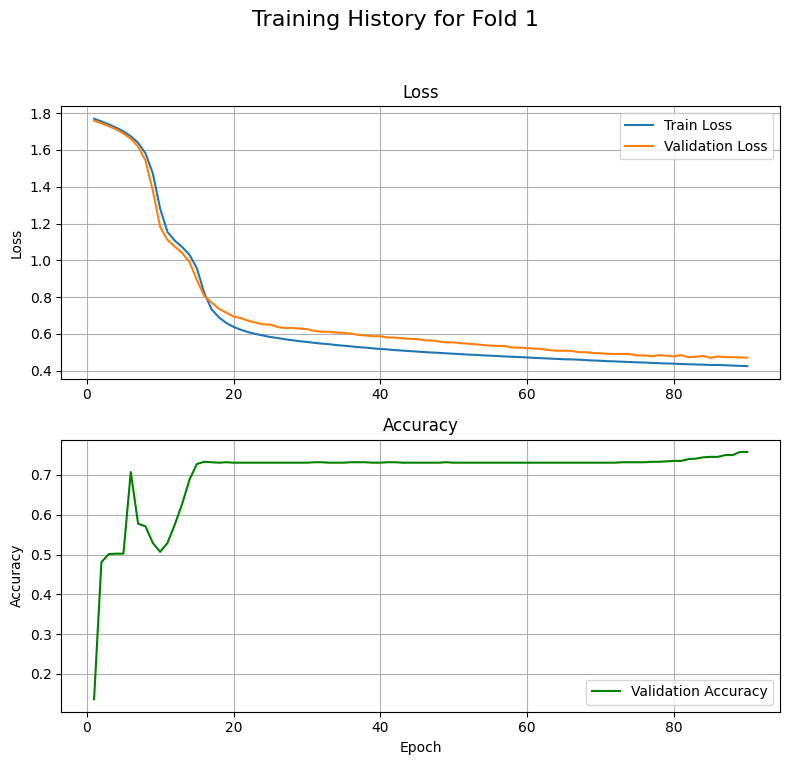

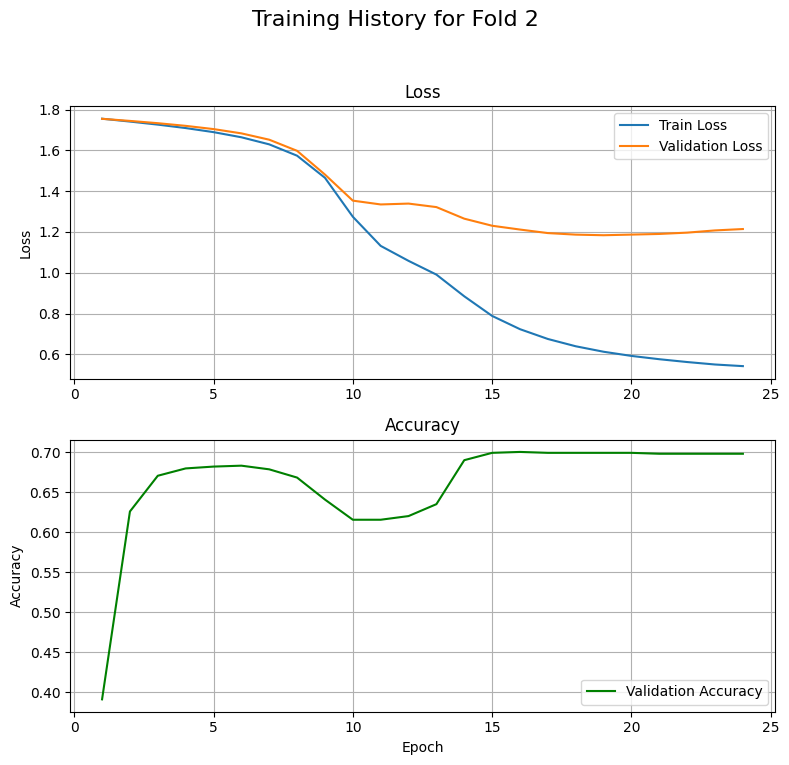

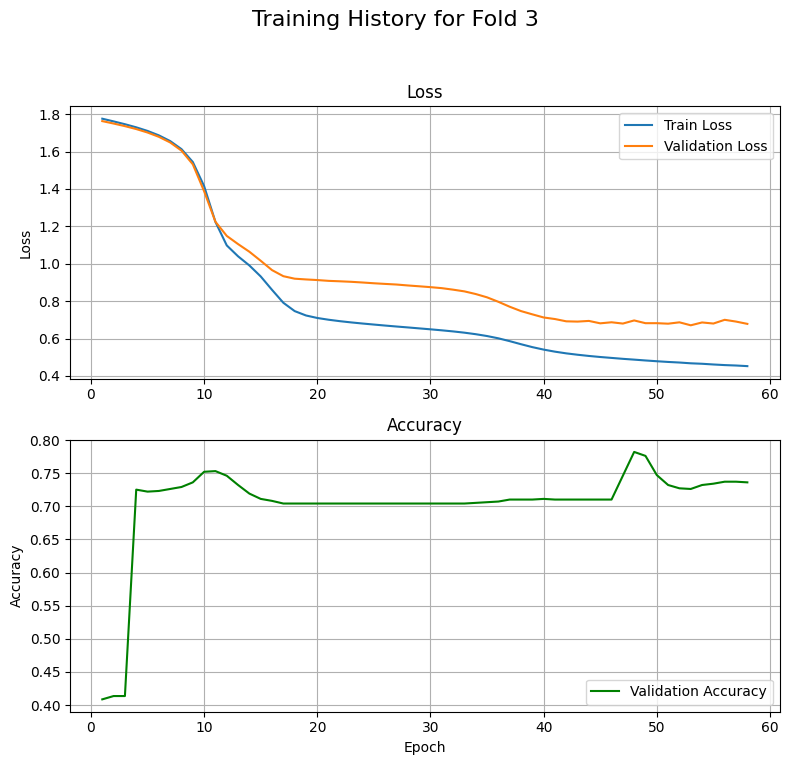

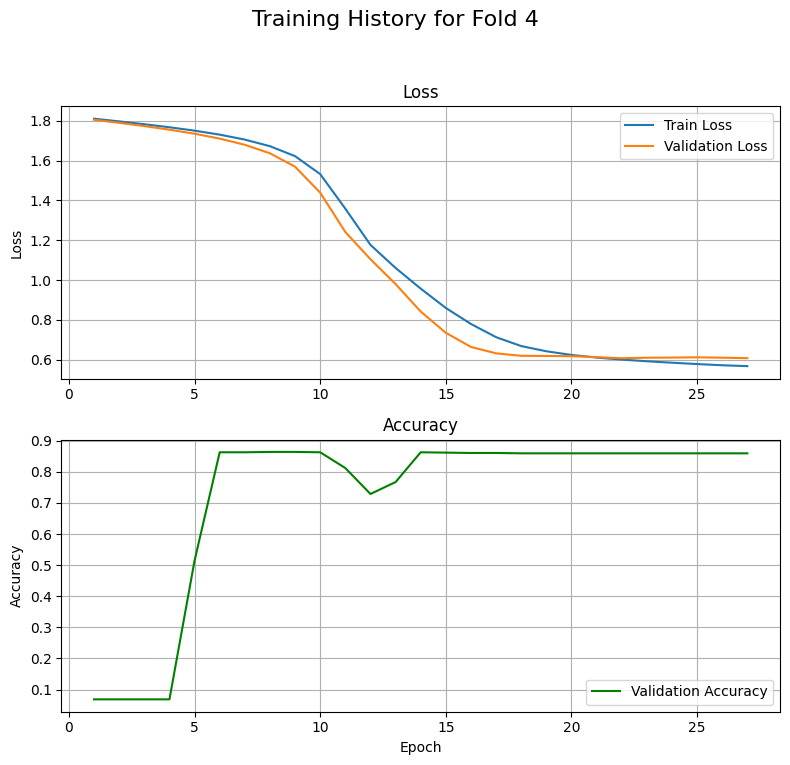

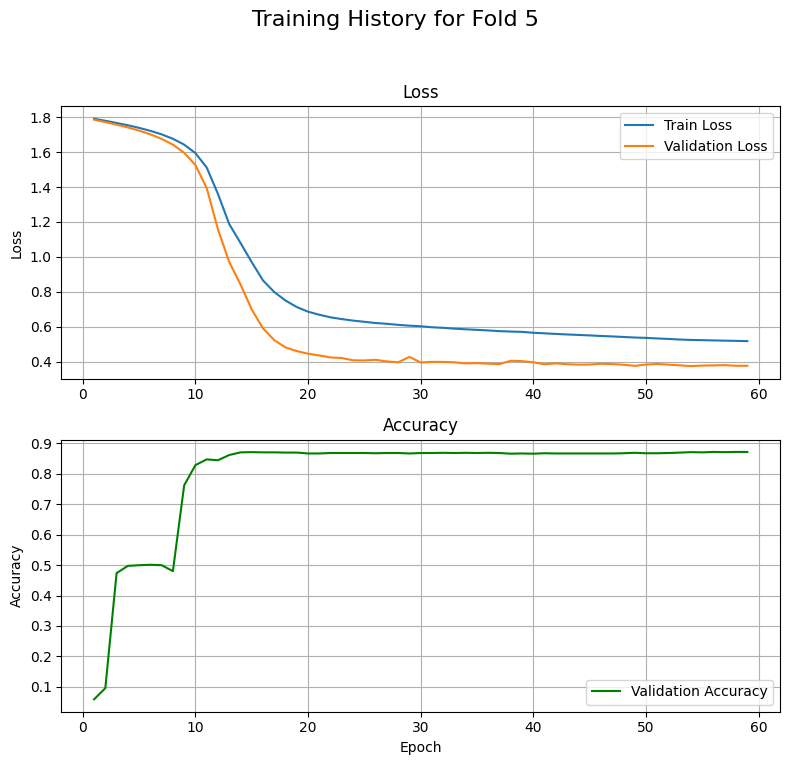

In [25]:
import matplotlib.pyplot as plt

for hist in fold_histories:
    fold = hist['fold']
    epochs = len(hist['history']['train_loss']) # Assuming train_loss, val_loss, and val_acc have the same length
    epoch_range = range(1, epochs + 1)

    # Create a figure and a set of subplots for each fold
    fig, axes = plt.subplots(2, 1, figsize=(8, 8))
    fig.suptitle(f'Training History for Fold {fold}', fontsize=16)

    # Plot Training and Validation Loss
    axes[0].plot(epoch_range, hist['history']['train_loss'], label='Train Loss')
    axes[0].plot(epoch_range, hist['history']['val_loss'], label='Validation Loss')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss')
    axes[0].legend()
    axes[0].grid(True)

    # Plot Validation Accuracy
    axes[1].plot(epoch_range, hist['history']['val_acc'], label='Validation Accuracy', color='green')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].legend()
    axes[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust layout to prevent suptitle overlap
    plt.show()

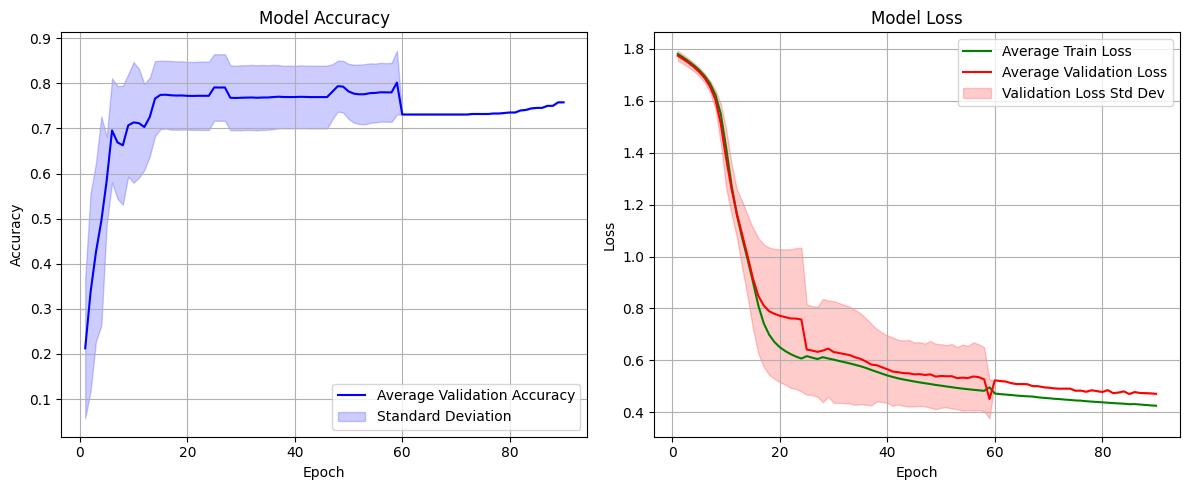

In [26]:
import numpy as np
import matplotlib.pyplot as plt

# --- 1. Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (FoldÎ≥Ñ Í∏∏Ïù¥Í∞Ä Îã¨ÎùºÎèÑ Ï≤òÎ¶¨ Í∞ÄÎä•ÌïòÎèÑÎ°ù) ---
# Ïù¥Ï†Ñ ÏΩîÎìúÏóêÏÑú fold_histories Î¶¨Ïä§Ìä∏Ïóê Í≤∞Í≥ºÍ∞Ä Ï†ÄÏû•ÎêòÏñ¥ ÏûàÎã§Í≥† Í∞ÄÏ†ï

# Í∞Å FoldÏùò history Î¶¨Ïä§Ìä∏ Ï∂îÏ∂ú
train_losses_folds = [h['history']['train_loss'] for h in fold_histories]
test_losses_folds = [h['history']['val_loss'] for h in fold_histories]
test_acc_folds = [h['history']['val_acc'] for h in fold_histories]

# Í∞ÄÏû• Í∏∏Í≤å ÌïôÏäµÌïú ÏóêÌè≠ Ïàò Ï∞æÍ∏∞
max_epochs = max([len(h) for h in train_losses_folds])

# NumPy Î∞∞Ïó¥Î°ú Î≥ÄÌôò (Í∏∏Ïù¥Í∞Ä ÏßßÏùÄ FoldÎäî NaNÏúºÎ°ú Ï±ÑÏõÄ)
def pad_history(histories, max_len):
    padded = np.full((len(histories), max_len), np.nan)
    for i, h in enumerate(histories):
        padded[i, :len(h)] = h
    return padded

all_train_losses = pad_history(train_losses_folds, max_epochs)
all_test_losses = pad_history(test_losses_folds, max_epochs)
all_test_accs = pad_history(test_acc_folds, max_epochs)

# --- 2. ÌèâÍ∑† Î∞è ÌëúÏ§ÄÌé∏Ï∞® Í≥ÑÏÇ∞ ---
mean_train_loss = np.nanmean(all_train_losses, axis=0)
std_train_loss = np.nanstd(all_train_losses, axis=0)

mean_test_loss = np.nanmean(all_test_losses, axis=0)
std_test_loss = np.nanstd(all_test_losses, axis=0)

mean_test_acc = np.nanmean(all_test_accs, axis=0)
std_test_acc = np.nanstd(all_test_accs, axis=0)

# --- 3. Í∑∏ÎûòÌîÑ Í∑∏Î¶¨Í∏∞ ---
epoch_range = range(1, max_epochs + 1)

# Ï†ïÌôïÎèÑ(Accuracy) Í∑∏ÎûòÌîÑ
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epoch_range, mean_test_acc, 'b-', label='Average Validation Accuracy')
plt.fill_between(epoch_range,
                 mean_test_acc - std_test_acc,
                 mean_test_acc + std_test_acc,
                 color='blue', alpha=0.2, label='Standard Deviation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# ÏÜêÏã§(Loss) Í∑∏ÎûòÌîÑ
plt.subplot(1, 2, 2)
plt.plot(epoch_range, mean_train_loss, 'g-', label='Average Train Loss')
plt.plot(epoch_range, mean_test_loss, 'r-', label='Average Validation Loss')
plt.fill_between(epoch_range,
                 mean_test_loss - std_test_loss,
                 mean_test_loss + std_test_loss,
                 color='red', alpha=0.2, label='Validation Loss Std Dev')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [28]:
# --- üí° ÏÉàÎ°úÏö¥ Î∂ÄÎ∂Ñ: Ï†ÑÏ≤¥ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°ú Ïû¨ÌïôÏäµ ---
print(f"\n===================== Retraining on Full Training Data =====================")
# 1. CVÏóêÏÑú Ï∞æÏùÄ ÏµúÏ†ÅÏùò ÏóêÌè¨ÌÅ¨ ÏàòÎ•º ÌèâÍ∑†ÎÇ¥Ïñ¥ Í≤∞Ï†ï (ÏÜåÏàòÏ†ê Î≤ÑÎ¶º)
optimal_epochs = int(np.mean(stopped_epochs))
print(f"Optimal epochs determined from CV: {optimal_epochs}")

# 2. Ï†ÑÏ≤¥ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î•º ÏúÑÌïú DataLoader ÏÉùÏÑ±
X_train_full, y_train_full = get_frames(train_df, frame_size, hop_size)
X_train_full_tensor = torch.tensor(X_train_full, dtype=torch.float32)
y_train_full_tensor = torch.tensor(y_train_full, dtype=torch.long)

full_train_dataset = TensorDataset(X_train_full_tensor, y_train_full_tensor)
full_train_loader = DataLoader(full_train_dataset, batch_size=batch_size, shuffle=True)

# 3. ÏµúÏ¢Ö Î™®Îç∏ÏùÑ ÏúÑÌïú ÏÉàÎ°úÏö¥ Î™®Îç∏ Í∞ùÏ≤¥ ÏÉùÏÑ± Î∞è Ï¥àÍ∏∞Ìôî
final_model = LSTMClassifier(input_size=4, hidden_size=100, num_layers=2, num_classes=6).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(final_model.parameters(), lr=0.00001, weight_decay=1e-4)

# 4. Ï†ÑÏ≤¥ ÌõàÎ†® Îç∞Ïù¥ÌÑ∞Î°ú `optimal_epochs` ÎßåÌÅº ÌïôÏäµ
for epoch in range(optimal_epochs):
    final_model.train()
    running_loss = 0.0
    for inputs, labels in full_train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = final_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * inputs.size(0)
    
    epoch_loss = running_loss / len(full_train_loader.dataset)
    print(f"Retraining Epoch [{epoch+1}/{optimal_epochs}], Loss: {epoch_loss:.4f}")

print("Retraining finished.")



===================== Retraining on Full Training Data =====================
Optimal epochs determined from CV: 98
Retraining Epoch [1/98], Loss: 1.7767
Retraining Epoch [2/98], Loss: 1.7594
Retraining Epoch [3/98], Loss: 1.7406
Retraining Epoch [4/98], Loss: 1.7184
Retraining Epoch [5/98], Loss: 1.6899
Retraining Epoch [6/98], Loss: 1.6493
Retraining Epoch [7/98], Loss: 1.5802
Retraining Epoch [8/98], Loss: 1.4336
Retraining Epoch [9/98], Loss: 1.2133
Retraining Epoch [10/98], Loss: 1.0958
Retraining Epoch [11/98], Loss: 1.0354
Retraining Epoch [12/98], Loss: 0.9780
Retraining Epoch [13/98], Loss: 0.9004
Retraining Epoch [14/98], Loss: 0.8063
Retraining Epoch [15/98], Loss: 0.7480
Retraining Epoch [16/98], Loss: 0.7232
Retraining Epoch [17/98], Loss: 0.7062
Retraining Epoch [18/98], Loss: 0.6901
Retraining Epoch [19/98], Loss: 0.6718
Retraining Epoch [20/98], Loss: 0.6496
Retraining Epoch [21/98], Loss: 0.6240
Retraining Epoch [22/98], Loss: 0.6005
Retraining Epoch [23/98], Loss: 0.5


===================== Final Evaluation with Retrained Model =====================

### Final Test Set Classification Report ###
              precision    recall  f1-score   support

  Downstairs       0.11      0.02      0.04       384
     Jogging       0.98      0.94      0.96      1313
     Sitting       0.56      0.95      0.71        63
    Standing       0.00      0.00      0.00        48
    Upstairs       0.35      0.72      0.47       405
     Walking       0.80      0.77      0.79      1328

    accuracy                           0.74      3541
   macro avg       0.47      0.57      0.49      3541
weighted avg       0.73      0.74      0.72      3541


### Final Test Set Confusion Matrix ###


c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\c\Desktop\ML programming\venv\lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result)

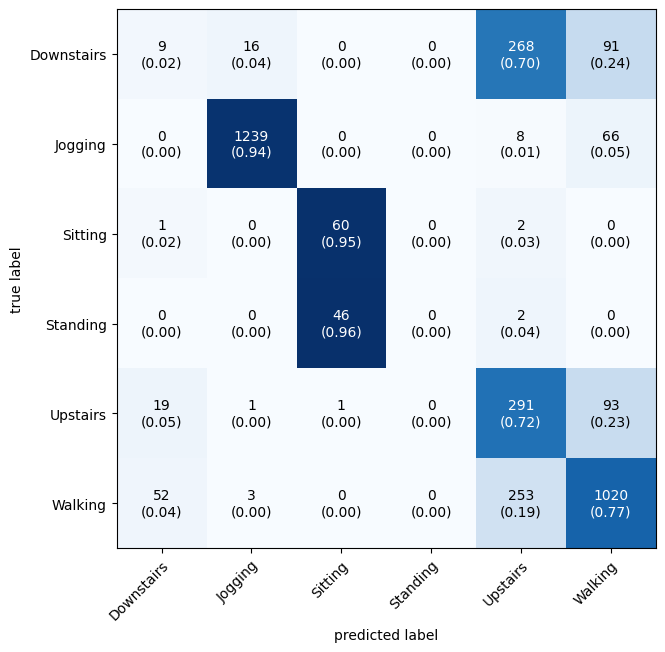

In [30]:
print(f"\n===================== Final Evaluation with Retrained Model =====================")
final_model.eval() # ÌèâÍ∞Ä Î™®ÎìúÎ°ú ÏÑ§Ï†ï

# ÌÖåÏä§Ìä∏ Îç∞Ïù¥ÌÑ∞ Ï§ÄÎπÑ (Í∏∞Ï°¥ ÏΩîÎìúÏôÄ ÎèôÏùº)
feature_cols = ['x_std', 'y_std', 'z_std', 'magnitude_std']
X_test, y_test = get_frames(test_df, frame_size, hop_size)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# final_modelÏùÑ ÏÇ¨Ïö©ÌïòÏó¨ ÏµúÏ¢Ö ÏòàÏ∏° ÏàòÌñâ
all_test_predictions = []
all_test_labels = []
with torch.no_grad():
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = final_model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_test_predictions.extend(predicted.cpu().numpy())
        all_test_labels.extend(labels.numpy())
        
# ÏµúÏ¢Ö Í≤∞Í≥º Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî (Í∏∞Ï°¥ ÏΩîÎìúÏôÄ ÎèôÏùº)
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

print("\n### Final Test Set Classification Report ###")
print(classification_report(all_test_labels, all_test_predictions, target_names=label_encoder.classes_))

print("\n### Final Test Set Confusion Matrix ###")
mat = confusion_matrix(all_test_labels, all_test_predictions)
plot_confusion_matrix(
    conf_mat=mat,
    class_names=label_encoder.classes_,
    show_normed=True,
    figsize=(7, 7)
)
plt.show()